<a href="https://colab.research.google.com/github/TGAmbra/GSOC-2023/blob/main/GSOC_MultiG_Keras_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learning to Generate 3D Shapes from a Single Example**

In [ ]:
!pip install pyglet
!pip install PyMCubes
!pip install trimesh
!pip install protobuf
!apt-get -y install protobuf-compiler python-pil python-lxml
!pip install --upgrade protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.0/687.0 kB 14.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pil
E: Unable to locate package python-lxml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


In [ ]:
import h5py
import numpy
import PIL
import os
import pyglet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.math import reduce_mean
from tensorflow.python.ops.gen_nn_ops import leaky_relu
import mcubes
import skimage
import scipy
import tqdm
import trimesh

import google.protobuf
print(h5py.__version__, numpy.__version__, PIL.__version__,
      skimage.__version__, scipy.__version__, tqdm.__version__, trimesh.__version__,
      google.protobuf.__version__)

#check if you need to update numpy, PIL, scipy


3.9.0 1.23.5 9.4.0 0.19.3 1.11.3 4.66.1 4.0.0 3.20.3


h5py==3.6.0
numpy==1.22.3
Pillow==9.0.1
pyglet==1.5.26
PyMCubes==0.1.2
scikit-image==0.19.2
scipy==1.7.3
torch>=1.11.0
tqdm==4.64.0
trimesh==3.12.5
open3d==0.15.2
tensorboardX==2.5 use keras function
protobuf==3.20.2

In [ ]:
## Visualise model and load file from url
#Loading file from url
path_to_downloaded_file = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/data/elm_small_spring.obj",
)
path = os.path.join(os.path.dirname(path_to_downloaded_file), 'elm_small_spring.obj')
print(path)
mesh = trimesh.load(path)
mesh.show()

164686/164686 [==============================] - 0s 2us/step
/root/.keras/datasets/elm_small_spring.obj


In [ ]:
#Voxelise and normalise
import numpy as np
# normalise within unit sphere:
def normalize_unit_sphere(vertices):
  mean_vertices = np.mean(vertices, axis=0)
  vertices -= mean_vertices # mean subtracted from all vertices
  max_distance = np.max(np.sqrt(np.sum(abs(vertices)**2,axis=-1))) #max distance from origin
  vertices /= max_distance #all vertices are divided by the maximum of such distances
  #All distances are scaled to the range -1.0 and 1.0.
  return vertices

# binary mask and padding to create filling
t_voxels = mesh.voxelized(0.025) #0.001 crashed my ram
#print(t_voxels)
original_voxels=t_voxels.matrix.astype(int)
#print(voxels.shape)
original_voxels = np.pad(original_voxels, 1) #pads 0 around occupied voxels
print(original_voxels.shape)

(115, 179, 106)


In [ ]:
#Voxelise and normalise for generator N
# binary mask and padding to create filling
t_voxels = mesh.voxelized(0.01235)
# at 0.0124: (226, 355, 209), after padding: (228, 357, 211)
#at 0.01235: (227, 357, 210), after padding: (229, 359, 212)
#print(t_voxels)
big_voxels=t_voxels.matrix.astype(int)
print(big_voxels.shape)
big_voxels = np.pad(big_voxels,((1,2),(0,1),(1,1))) #pads 0 around occupied voxels
print(big_voxels.shape)

(227, 357, 210)
(230, 358, 212)


In [ ]:
#3D output = output channels, height/width/depth (2 of them)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def make_projection_model(out_channels, input_shape):
  # Create input layer
  input_data = tf.keras.Input(shape=(out_channels,*input_shape))
  # Apply AveragePooling3D with adjusted pool dimensions
  fmap = tf.keras.layers.AveragePooling3D(pool_size=(1,1,1),data_format='channels_first')
  yz_fmap = tf.reduce_mean(fmap(input_data), 4)# across W
  xz_fmap = tf.reduce_mean(fmap(input_data), 3)# across H
  xy_fmap = tf.reduce_mean(fmap(input_data), 2)#across D
  # No need to re-order dimensions DxHxW with tf.mean
  #tf.print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)
  #Apply convolutions
  convolution = layers.Conv2D(out_channels, (1, 1), strides=(1, 1),data_format='channels_first')
  yz_fmap = convolution(yz_fmap)
  xz_fmap = convolution(xz_fmap)
  xy_fmap = convolution(xy_fmap)
  #tf.print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)
  model = keras.Model(inputs=input_data, outputs=[yz_fmap, xz_fmap, xy_fmap], name="projection_model")
  #model.summary()
  return model

#pool_dims = 8
out_channels = 32
input_shape = (115, 179, 106)
projection_model = make_projection_model(out_channels, input_shape)
projection_model.summary()

# #Run only if enough GPU RAM
#noise = tf.random.normal((1,115, 179, 106))
noise = tf.random.normal((1,*original_voxels.shape))
noise = tf.tile(tf.expand_dims(noise, 1), [1, out_channels, 1, 1, 1])
print(noise.shape)
yz_fmap, xz_fmap, xy_fmap = projection_model(noise)
print(yz_fmap.shape, xz_fmap.shape, xy_fmap.shape)

Num GPUs Available:  1
Model: "projection_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 115, 179, 106)   0         []                            
                             ]                                                                    
                                                                                                  
 average_pooling3d_1 (Avera  (None, 32, 115, 179, 106)    0         ['input_2[0][0]',             
 gePooling3D)                                                        'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 tf.math.reduce_mean_3 (TFO  (None, 32, 115, 179)         0 

In [ ]:
# make G0 model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def make_generator0_model(output_channels,input_shape_yz,input_shape_xz, input_shape_xy):
  #Define inputs
  yz_fmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
  xz_fmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
  xy_fmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))
  #Convolution block
  conv_layer = tf.keras.layers.Conv2D(output_channels, (3,3), strides=(1, 1),data_format="channels_first", padding = "same") #passing same to get 256 instead of 254
  in_layer = tf.keras.layers.BatchNormalization(axis=-1) # axis=-1 last dimension has to match, to re use the layer
  # create new instance normalisation layer as yz_fmap has different last dimension
  in__layer = tf.keras.layers.BatchNormalization(axis=-1)
  lrelu_layer = layers.LeakyReLU(alpha = 0.2) #negative slope=0.2
  #Apply the convolution block to each feature_map
  xy_tmap = lrelu_layer(in_layer(conv_layer(xy_fmap)))
  xz_tmap = lrelu_layer(in_layer(conv_layer(xz_fmap)))
  yz_tmap = lrelu_layer(in__layer(conv_layer(yz_fmap)))
  #tf.print(yz_tmap.shape, xz_tmap.shape, xy_tmap.shape)
  model = keras.Model(inputs=[yz_fmap, xz_fmap, xy_fmap], outputs=[yz_tmap, xz_tmap, xy_tmap], name="generator0_model")
  return model

output_channels = 32

##Uncomment if you have 40+ GPU RAM
# input_shape_yz = yz_fmap.numpy().shape[-2:]
# input_shape_xz= xz_fmap.numpy().shape[-2:]
# input_shape_xy= xy_fmap.numpy().shape[-2:]

input_shape_yz = (115, 179)
input_shape_xz= (115, 106)
input_shape_xy= (179, 106)
#print(input_shape_yz,input_shape_xz, input_shape_xy)
generator0_model = make_generator0_model(output_channels, input_shape_yz,input_shape_xz, input_shape_xy)
generator0_model.summary()
##Uncomment if you have 40+ GPU RAM
# yz_tmap, xz_tmap, xy_tmap = generator0_model([yz_fmap, xz_fmap, xy_fmap]) #no last convolution
# print(yz_tmap.shape, xz_tmap.shape, xy_tmap.shape)


Model: "generator0_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 115, 179)]       0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 32, 115, 106)]       0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 32, 179, 106)]       0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           multiple                     9248      ['input_5[0][0]',             
                                                                     'input_4[0][0]

In [ ]:
# make GN model
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#grows in size
def make_generatorN_model(output_channels,input_shape_yz, input_shape_xz, input_shape_xy):
  #Define inputs
  yz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
  xz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
  xy_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))

  #Bilinear upsample to add details
  #randomly chosen size
  upsample_layer = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = "bilinear",data_format="channels_first")
  yz_tmap_out = upsample_layer(yz_tmap) #shape = (None, 32, 508, 508)
  xz_tmap_out = upsample_layer(xz_tmap)
  xy_tmap_out = upsample_layer(xy_tmap)

  #Add noise
  yz_tmap_out = yz_tmap_out+tf.random.normal((1,*yz_tmap_out.shape[1:]))
  xz_tmap_out = xz_tmap_out+tf.random.normal((1,*xz_tmap_out.shape[1:]))
  xy_tmap_out = xy_tmap_out+tf.random.normal((1,*xy_tmap_out.shape[1:]))
  # tf.print(xz_tmap_out.shape, xy_tmap_out.shape,yz_tmap_out.shape)
  # tf.print(xz_tmap.shape, xy_tmap.shape,yz_tmap.shape)

  #Convolution block
  conv_layer = layers.Conv2D(32, (3,3), strides=(1, 1),data_format="channels_first", padding="same")
  in_layer = layers.BatchNormalization(axis=-1)
  in__layer = layers.BatchNormalization(axis=-1)
  lrelu_layer = layers.LeakyReLU(alpha = 0.2) #negative slope=0.2

  #Apply the convolution block to each feature_map
  xz_tmap_out = lrelu_layer(in_layer(conv_layer(xz_tmap_out)))
  xy_tmap_out = lrelu_layer(in_layer(conv_layer(xy_tmap_out)))
  yz_tmap_out = lrelu_layer(in__layer(conv_layer(yz_tmap_out)))

  #Residual/Skip-add connections
  #Use zero-padding and conv2D to make input shapes match
  #Create custom padding layer as all shapes are different
  #((top_pad, bottom_pad), (left_pad, right_pad))
  zero_pad_layer_yz = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in yz_tmap.shape[-2:]), data_format="channels_first")
  zero_pad_layer_xz = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in xz_tmap.shape[-2:]), data_format="channels_first")
  zero_pad_layer_xy = layers.ZeroPadding2D(padding=tuple((math.floor(ti/2), math.ceil(ti/2)) for ti in xy_tmap.shape[-2:]), data_format="channels_first")

  #print(zero_pad_layer_yz(conv_layer(yz_tmap)).shape, yz_tmap_out.shape)
  yz_tmap_out = layers.Add()([yz_tmap_out, zero_pad_layer_yz(conv_layer(yz_tmap))])
  xz_tmap_out = layers.Add()([xz_tmap_out, zero_pad_layer_xz(conv_layer(xz_tmap))])
  xy_tmap_out = layers.Add()([xy_tmap_out, zero_pad_layer_xy(conv_layer(xy_tmap))])
  #tf.print(yz_tmap_out.shape, xz_tmap_out.shape, xy_tmap_out.shape)
  model = keras.Model(inputs=[yz_tmap, xz_tmap, xy_tmap], outputs=[yz_tmap_out, xz_tmap_out, xy_tmap_out], name="generatorN_model")
  return model

output_channels = 32
##Uncomment if you have 40+ GPU RAM
# input_shape_yz = yz_tmap.numpy().shape[-2:]
# input_shape_xz= xz_tmap.numpy().shape[-2:]
# input_shape_xy= xy_tmap.numpy().shape[-2:]

input_shape_yz = (115, 179)
input_shape_xz = (115, 106)
input_shape_xy = (179, 106)
print(input_shape_yz, input_shape_xz, input_shape_xy)
generatorN_model = make_generatorN_model(output_channels, input_shape_yz, input_shape_xz, input_shape_xy)
generatorN_model.summary()

##Uncomment if you have 40+ GPU RAM
# yz_tmap_out, xz_tmap_out, xy_tmap_out = generatorN_model([yz_tmap, xz_tmap, xy_tmap]) #no last convolution
# print(yz_tmap_out.shape, xz_tmap_out.shape, xy_tmap_out.shape)

(115, 179) (115, 106) (179, 106)
Model: "generatorN_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 32, 115, 179)]       0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 32, 115, 106)]       0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 32, 179, 106)]       0         []                            
                                                                                                  
 up_sampling2d (UpSampling2  multiple                     0         ['input_14[0][0]',            
 D)                                               

In [ ]:
## Grid sampling functions
import tensorflow as tf
#@tf.function
def make_coords(H, W, D, normalize=True):
        # Create coordinate grids using meshgrid
        #normalise values between -1 and 1
    xs, ys, zs = tf.meshgrid(
        tf.linspace(-1.0, 1.0, H) if normalize else tf.range(H, dtype=tf.float32),
        tf.linspace(-1.0, 1.0, W) if normalize else tf.range(W, dtype=tf.float32),
        tf.linspace(-1.0, 1.0, D) if normalize else tf.range(D, dtype=tf.float32),
        indexing='ij'
    )

    # Stack the coordinate grids to create the final coordinates tensor
    coords = tf.stack([xs, ys, zs], axis=-1)
    #print(coords.shape)

    return coords

# Perform bilinear interpolation for each feature map
#weighted sum of the values of the four nearest grid points in the feature map based on the interpolation weights
#@tf.function
def bilinear_interpolation(feat_map, x, y, z, coord_x, coord_y,coord_z):
  # Prepare indices for interpolation
    x0 = coord_x
    x1 = x0 + 1
    y0 = coord_y
    y1 = y0 + 1
    z0 = coord_z
    z1 = z0 + 1

    # Ensure indices are within valid range
    # avoid out-of-bounds access (0 to H-1, 0 to W-1, 0 to D-1)
    x0 = tf.clip_by_value(x0, 0, input_shape[0] - 1)
    x1 = tf.clip_by_value(x1, 0, input_shape[0] - 1)
    y0 = tf.clip_by_value(y0, 0, input_shape[1] - 1)
    y1 = tf.clip_by_value(y1, 0, input_shape[1] - 1)
    z0 = tf.clip_by_value(z0, 0, input_shape[2] - 1)
    z1 = tf.clip_by_value(z1, 0, input_shape[2] - 1)

    # weights
    w000 = (1 - x) * (1 - y) * (1 - z)
    w100 = x * (1 - y) * (1 - z)
    w010 = (1 - x) * y * (1 - z)
    w110 = x * y * (1 - z)
    w001 = (1 - x) * (1 - y) * z
    w101 = x * (1 - y) * z
    w011 = (1 - x) * y * z
    w111 = x * y * z

#stack weights together
    indices_000 = tf.stack([x0, y0, z0], axis=1)
    indices_100 = tf.stack([x1, y0, z0], axis=1)
    indices_010 = tf.stack([x0, y1, z0], axis=1)
    indices_110 = tf.stack([x1, y1, z0], axis=1)
    indices_001 = tf.stack([x0, y0, z1], axis=1)
    indices_101 = tf.stack([x1, y0, z1], axis=1)
    indices_011 = tf.stack([x0, y1, z1], axis=1)
    indices_111 = tf.stack([x1, y1, z1], axis=1)

#Get values of 8 surrounding data points
    value_000 = tf.gather_nd(feat_map, indices_000)
    value_100 = tf.gather_nd(feat_map, indices_100)
    value_010 = tf.gather_nd(feat_map, indices_010)
    value_110 = tf.gather_nd(feat_map, indices_110)
    value_001 = tf.gather_nd(feat_map, indices_001)
    value_101 = tf.gather_nd(feat_map, indices_101)
    value_011 = tf.gather_nd(feat_map, indices_011)
    value_111 = tf.gather_nd(feat_map, indices_111)

    #print(w000[..., tf.newaxis].shape, value_000.shape)
    #GN: (17456080, 1) (17456080, 32)

    interpolated_value = (
        w000[..., tf.newaxis] * value_000 +
        w100[..., tf.newaxis] * value_100 +
        w010[..., tf.newaxis] * value_010 +
        w110[..., tf.newaxis] * value_110 +
        w001[..., tf.newaxis] * value_001 +
        w101[..., tf.newaxis] * value_101 +
        w011[..., tf.newaxis] * value_011 +
        w111[..., tf.newaxis] * value_111
    )

    return interpolated_value


#(2182010, 32) (2182010, 32) (2182010, 32)
#yz_tmap_out, xz_tmap_out, xy_tmap_out

In [ ]:
# make MLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# MLP Architecture
def make_MLP_model(input_shape_yz,input_shape_xz, input_shape_xy, output_channels,training):
    #Define inputs
    yz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_yz))
    xz_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xz))
    xy_tmap = tf.keras.Input(shape=(output_channels,*input_shape_xy))
    #print(input_shape_yz[0],input_shape_yz[1], input_shape_xz[1])
    #Define layers
    permute_layer = layers.Permute((2,3,1)) #dense inputs channels last
    relu_layer = layers.Dense(32, activation='relu')
    sigmoid_layer = layers.Dense(1, activation='sigmoid')
    #Define output features
    yz_map = relu_layer(permute_layer(yz_tmap))
    xz_map = relu_layer(permute_layer(xz_tmap))
    xy_map = relu_layer(permute_layer(xy_tmap))
    #print(yz_map.shape, xz_map.shape, xy_map.shape)

    # Define grid dimensions
    # Each row = 3D coord point in the grid , Assuming coords has shape (115, 179, 106, 3)
    coord = make_coords(input_shape_yz[0],input_shape_yz[1], input_shape_xz[1])
    #print(coord.shape)
    coords_reshaped = tf.reshape(coord, [-1, 3])  # Reshape coords to (H*W*D, 3)
    #print(coords_reshaped.shape)
    # Extract individual components of coordinates
    #Floor coordinates to integers for indexing
    # rounds each coord of grid to nearest int and double check that only int32 values are there
    coord_x = tf.cast(tf.math.floor(coords_reshaped[:, 0]), dtype=tf.int32)
    coord_y = tf.cast(tf.math.floor(coords_reshaped[:, 1]), dtype=tf.int32)
    coord_z = tf.cast(tf.math.floor(coords_reshaped[:, 2]), dtype=tf.int32)

    # Calculate the weights for interpolation
    #Get fractional part of each coord
    x_weight = coords_reshaped[:, 0] - tf.cast(coord_x, dtype=tf.float32)# point x coord-float grid
    y_weight = coords_reshaped[:, 1] - tf.cast(coord_y, dtype=tf.float32)
    z_weight = coords_reshaped[:, 2] - tf.cast(coord_z, dtype=tf.float32)

    #GO: (2182010, 32) (2182010, 32) (2182010, 32)
    #GN: (17456080, 32)
    sample_yz_feat = bilinear_interpolation(yz_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    sample_xz_feat = bilinear_interpolation(xz_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    sample_xy_feat = bilinear_interpolation(xy_map, x_weight, y_weight, z_weight,coord_x, coord_y,coord_z)
    print("finished bilinear interpo")
    # Reshape the sampled features to match your desired shape
    sample_yz_feat = tf.reshape(sample_yz_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    sample_xz_feat = tf.reshape(sample_xz_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    sample_xy_feat = tf.reshape(sample_xy_feat, [input_shape_yz[0], input_shape_yz[1], input_shape_xz[1], 32])
    #print(sample_xy_feat.shape, sample_xz_feat.shape,  sample_yz_feat.shape)
    #Define occupancy probability volume
    o_p = sigmoid_layer(tf.keras.layers.Concatenate(axis=-1)([sample_xy_feat, sample_xz_feat,  sample_yz_feat]))
    #tf.print("finished op", o_p.shape)
    model = keras.Model(inputs=[yz_tmap, xz_tmap, xy_tmap], outputs=o_p, name="MLP_train_model")
    return model

#Occupancy probability: the probability of 𝑝 being occupied by the 3D shape.
output_channels = 32
##Uncomment if you have 40+ GPU RAM
# input_shape_yz_small = yz_tmap.numpy().shape[-2:]
# input_shape_xz_small= xz_tmap.numpy().shape[-2:]
# input_shape_xy_small= xy_tmap.numpy().shape[-2:]
# input_shape_yz_big = yz_tmap_out.numpy().shape[-2:]
# input_shape_xz_big= xz_tmap_out.numpy().shape[-2:]
# input_shape_xy_big= xy_tmap_out.numpy().shape[-2:]
# print(input_shape_yz_small,input_shape_xz_small, input_shape_xy_small)
# print(input_shape_yz_big,input_shape_xz_big, input_shape_xy_big)

input_shape_yz_small = (115, 179)
input_shape_xz_small= (115, 106)
input_shape_xy_small= (179, 106)
input_shape_yz_big = (230, 358)
input_shape_xz_big= (230, 212)
input_shape_xy_big= (358, 212)
training = True
#training = False
mlp_small = make_MLP_model(input_shape_yz_small,input_shape_xz_small, input_shape_xy_small,output_channels, training)
mlp_small.summary()
mlp_big = make_MLP_model(input_shape_yz_big,input_shape_xz_big, input_shape_xy_big,output_channels, training)
mlp_big.summary()

###Uncomment if you have 40+ GPU RAM
# o_p_small= mlp_small([yz_tmap, xz_tmap, xy_tmap])
# print(o_p_small.shape)
# o_p_big= mlp_big([yz_tmap_out, xz_tmap_out, xy_tmap_out])
# print(o_p_big.shape) #(230, 358, 212, 1) (230, 358, 212)


finished bilinear interpo
Model: "MLP_train_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 179, 106)]       0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 32, 115, 106)]       0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 32, 115, 179)]       0         []                            
                                                                                                  
 permute (Permute)           multiple                     0         ['input_6[0][0]',             
                                                          

In [ ]:
from tensorflow.python.ops.gen_nn_ops import leaky_relu
from tensorflow import keras
def make_discriminator_model(input_shape,output_channels):
  #Define inputs output_channels
  print(input_shape)
  voxels = tf.keras.Input(shape=(output_channels,*input_shape))#input of conv3d must be channels last
  print(voxels.shape)
  #Define layer
  convo_layer = tf.keras.layers.Conv3D(output_channels,(3,3,3), strides=(2,2,2), padding='same',data_format="channels_first")
  last_convo = tf.keras.layers.Conv3D(1,(3,3,3), strides=(2,2,2), padding='same',data_format="channels_first")
  batch_norm = tf.keras.layers.BatchNormalization(axis=1)
  leaky_layer = tf.keras.layers.LeakyReLU()
  #Concatenate all together
  output_first_convo_block = leaky_layer(batch_norm(convo_layer(voxels)))
  output_sec_convo_block = leaky_layer(batch_norm(convo_layer(output_first_convo_block)))
  score_map = last_convo(output_sec_convo_block)
  #Exclude the channels dimension
  #tf.print(score_map.shape)
  model = keras.Model(inputs=[voxels], outputs=score_map, name="discriminator_model")
  return model

output_channels = 32
# ##score map for generated voxels gen0
##Uncomment if you have 40+ GPU RAM
# input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_small), 0), 0), [1,output_channels,  1, 1, 1])
# print(input_voxels.shape)
input_shape = (115, 179, 106)
discriminator_small = make_discriminator_model(input_shape, output_channels)
discriminator_small.summary()
##Uncomment if you have 40+ GPU RAM
# gen0_score_map = discriminator_small([input_voxels]) #generator 0 score map

# ##make score map for original model small
# original_input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(original_voxels, 0), 0), [1,output_channels, 1, 1, 1])
# print(original_input_voxels.shape)
# original_score_map = discriminator_small([original_input_voxels])#original input score map
# print(gen0_score_map.shape, original_score_map.shape)

# ##score map for generated voxels genN
##Uncomment if you have 40+ GPU RAM
# generated_voxels_big = tf.squeeze(o_p_big)
# a_big = tf.expand_dims(generated_voxels_big, 0)
# input_voxels_big = tf.tile(tf.expand_dims(a_big, 0), [1,output_channels,  1, 1, 1])

input_shape_big = (230, 358, 212)
discriminator_big = make_discriminator_model(input_shape_big, output_channels)
discriminator_big.summary()
##Uncomment if you have 40+ GPU RAM
# genN_score_map = discriminator_big([input_voxels_big]) #generator 0 score map

# #make score map for original model big
# original_input_voxels_big = tf.tile(tf.expand_dims(tf.expand_dims(big_voxels, 0), 4), [1, 1, 1, 1, output_channels])
# original_score_map_big = discriminator_big([original_input_voxels_big]) #orginal bi_voxels score map
# print(genN_score_map.shape, original_score_map_big.shape)

(115, 179, 106)
(None, 32, 115, 179, 106)
Model: "discriminator_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 32, 115, 179, 106)   0         []                            
                             ]                                                                    
                                                                                                  
 conv3d (Conv3D)             multiple                     27680     ['input_12[0][0]',            
                                                                     'leaky_re_lu_1[0][0]']       
                                                                                                  
 batch_normalization_2 (Bat  multiple                     128       ['conv3d[0][0]',              
 chNormalization)                     

In [ ]:
# @title Generator 0 only

#paper uses WGAP_GP method
class WGAN(keras.Model):
    def __init__(
        self,
        projection_model,
        generator0,
        generatorN,
        mlp_small,
        mlp_big,
        discriminator_small,
        discriminator_big,
        original_input_shape, #  (115, 179, 106)
        gradient_penalty_weight = 0.1,
        out_channels = 32,
    ):
        super().__init__()
        self.projection_model = projection_model
        self.generator0 = generator0
        self.generatorN = generatorN
        self.mlp_small = mlp_small
        self.mlp_big = mlp_big
        self.discriminator_small = discriminator_small
        self.discriminator_big = discriminator_big
        self.original_input_shape = original_input_shape # (115, 179, 106)
        self.gradient_penalty_weight = gradient_penalty_weight
        self.out_channels = out_channels

    def compile(self, discriminator_optimizer, generator_optimizer, recontruction_loss_fn, adversarial_loss_fn):
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.recontruction_loss_fn = recontruction_loss_fn #discriminator losss
        self.adversarial_loss_fn = adversarial_loss_fn #generator loss

    def gradient_penalty(self, batch_size, real_scores, fake_scores):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_scores - real_scores
        interpolated = real_scores + epsilon * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Choose correct discriminator
            if real_scores.shape[-3:] == (115, 179, 106):

              pred = self.discriminator_small(interpolated, training=True)
            else:
              pred = self.discriminator_big(interpolated, training=True)
        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, real_voxels, big_real_voxels=tf.expand_dims(big_voxels,0)):
        # Get the batch size
        batch_size = 1

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_small = self.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
          input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_small), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen0_score_map = self.discriminator_small([input_voxels], training=True)
          # Get the logits for the real occupancy score maps
          original_input_voxels = tf.tile(tf.expand_dims(real_voxels, 0), [batch_size,self.out_channels, 1, 1, 1])
          original_score_map = self.discriminator_small([original_input_voxels], training=True)
          # Calculate the gradient penalty
          gp = self.gradient_penalty(batch_size,tf.cast(original_input_voxels, tf.float32), tf.squeeze(o_p_small))
          # Calculate the dicriminator loss
          small_d_loss = self.adversarial_loss_fn(original_score_map,gen0_score_map)+ gp * self.gradient_penalty_weight
          ##Generator N
          # yz_tmap_out, xz_tmap_out, xy_tmap_out = self.generatorN([yz_tmap, xz_tmap, xy_tmap], training=True)
          # # Generate fake voxels from the feature maps
          # o_p_big = self.mlp_big([yz_tmap_out, xz_tmap_out, xy_tmap_out], training=True)
          # big_input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_big), 0), 0), [1,self.out_channels, 1, 1, 1])
          # # Get the logits for the fake occupancy score maps
          # genN_score_map = self.discriminator_big([big_input_voxels], training=True)
          # # big_original_score_map = self.discriminator_big([big_original_input_voxels], training=True)
          # # Calculate the discriminator loss
          # big_d_loss = self.adversarial_loss_fn(genN_score_map)

        # Get the gradients w.r.t the generators loss
        d0_gradient = tape.gradient(small_d_loss, self.discriminator_small.trainable_variables)
        # big_dtrainables = self.discriminator_small.trainable_variables+self.discriminator_big.trainable_variables
        # dN_gradient = tape.gradient(small_d_loss+big_d_loss, big_dtrainables)
        # print(dN_gradient)

        # Update the weights of the generator using the generator optimizer
        self.discriminator_optimizer.apply_gradients(
            zip(d0_gradient, self.discriminator_small.trainable_variables)
        )
        # self.discriminator_optimizer.apply_gradients(
        #     zip(dN_gradient, big_dtrainables)
        #)

        # Generator training
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [batch_size, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_small = self.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
          # input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_small), 0), 0), [batch_size,self.out_channels, 1, 1, 1])
          # # Get the logits for the fake occupancy score maps
          # gen0_score_map = self.discriminator_small([input_voxels], training=True)
          # # Get the logits for the real occupancy score maps
          # original_input_voxels = tf.tile(tf.expand_dims(real_voxels, 0), [batch_size,self.out_channels, 1, 1, 1])
          # #print(tf.squeeze(o_p_small).shape, tf.squeeze(real_voxels).shape)
          # Calculate the generator loss using the fake and real score maps
          #g_cost = self.recontruction_loss_fn(real=original_score_ map, reconstructed=gen0_score_map)
          g_cost = self.recontruction_loss_fn(real=tf.squeeze(real_voxels), reconstructed=tf.squeeze(o_p_small))
          # Add the gradient penalty to the original generator loss
          small_g_loss = g_cost

          ##Generator N
          # yz_tmap_out, xz_tmap_out, xy_tmap_out = self.generatorN([yz_tmap, xz_tmap, xy_tmap], training=True)
          # # Generate fake voxels from the feature maps
          # o_p_big = self.mlp_big([yz_tmap_out, xz_tmap_out, xy_tmap_out], training=True)
          # big_input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_big), 0), 0), [1,self.out_channels, 1, 1, 1])
          # # Get the logits for the fake occupancy score maps
          # genN_score_map = self.discriminator_big([big_input_voxels], training=True)
          # Get the logits for the real occupancy score maps
          # big_original_input_voxels = tf.tile(tf.expand_dims(big_real_voxels, 0), [batch_size,self.out_channels, 1, 1, 1])
          # # Calculate the generator loss using the fake and real score maps
          # big_g_cost = self.recontruction_loss_fn(real=tf.squeeze(big_real_voxels), reconstructed=tf.squeeze(o_p_big))
          # # Calculate the gradient penalty
          # big_gp = self.gradient_penalty(batch_size,tf.cast(big_original_input_voxels, tf.float32), tf.squeeze(o_p_big))
          # # Add the gradient penalty to the original generator loss
          # big_g_loss = big_g_cost + gp * self.gradient_penalty_weight

          # Get the gradients w.r.t the generator loss =
          small_trainables = self.projection_model.trainable_variables+self.generator0.trainable_variables+ self.mlp_small.trainable_variables
          # gen0_gradient = tape.gradient(small_g_loss,small_trainables)
          gen0_gradient = tape.gradient(g_cost,small_trainables)

          # big_trainables = small_trainables+self.generatorN.trainable_variables+ self.mlp_big.trainable_variables
          # genN_gradient = tape.gradient(small_g_loss+big_g_loss,big_trainables)

          # Update the weights of the generator using the generator optimizer
          self.generator_optimizer.apply_gradients(
              zip(gen0_gradient, small_trainables)
          )
          # self.generator_optimizer.apply_gradients(
          #     zip(genN_gradient, big_trainables)
          # )


        # return {"d_loss":big_d_loss, "g_loss": big_g_loss}
        return {"d0_loss": small_d_loss, "g0_loss": small_g_loss}
        # return {"g0_loss": small_g_loss}

In [ ]:
import tensorflow.keras.backend as K
# Hyperparameters
lr = 1e-4
beta1 = 0.5#exponential decay rate
epoch = 1000 #000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=epoch,
    decay_rate=beta1)
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule)

#Losses
"""The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). """
#@tf.function
def adversarial_loss(real, reconstructed, mode="D"):#discriminator loss
    loss = K.mean(reconstructed)-K.mean(real)
    return loss #aims to be around +0

#@tf.function
def reconstruction_loss(real, reconstructed): #generator loss
  adv_loss = -K.mean(reconstructed)
  alpha = 10
  mse = tf.keras.losses.MeanSquaredError()#mse(y_true, y_pred)
  loss = alpha*mse(real, reconstructed)+adv_loss
  return loss

In [ ]:
#Create a Keras callback that periodically saves shapes
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_gen=2, original_input_shape=(115, 179, 106)):
        self.num_gen = num_gen
        self.original_input_shape = original_input_shape

    def on_epoch_end(self, epoch, logs=None):
        random_latent_map = tf.random.normal(
            shape=(1, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, 32, 1, 1, 1])
        # Create tri-plane projection from random latent map
        yz_fmap, xz_fmap, xy_fmap = self.model.projection_model(random_latent_map, training=True)
        ##Generator 0
        # Generate feature maps from the projection feature planes
        yz_tmap, xz_tmap, xy_tmap = self.model.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
        # Generate fake voxels from the feature maps
        o_p_small = self.model.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
        if (epoch) % 250 == 0:
            for i in range(self.num_gen):
                voxels = tf.squeeze(o_p_small).numpy()
                print(voxels.shape)
                #break 3D array to 2d
                voxels_reshaped = voxels.reshape(voxels.shape[0], -1)
                np.savetxt("generated_shape_{i}_{epoch}.txt".format(i=i, epoch=epoch), voxels_reshaped)

In [ ]:
##train end-to end
# Instantiate the customer `GANMonitor` Keras callback.
#print(original_voxels.shape)
cbk = GANMonitor(num_gen=2, original_input_shape=original_voxels.shape)
generator_loss_list = []
discriminator_loss_list = []
# Get the wgan model
wgan = WGAN(
        projection_model = projection_model,
        generator0 = generator0_model,
        generatorN = generatorN_model,
        mlp_small = mlp_small,
        mlp_big = mlp_big,
        discriminator_small = discriminator_small,
        discriminator_big = discriminator_big,
        original_input_shape = original_voxels.shape,
        # generator_loss_list = generator_loss_list,
        # discriminator_loss_list = discriminator_loss_list
)

# Compile the wgan model
wgan.compile(
    discriminator_optimizer=discriminator_optimizer,
    generator_optimizer=generator_optimizer,
    adversarial_loss_fn=adversarial_loss,
    recontruction_loss_fn=reconstruction_loss,
)
early_stopping_cbk = tf.keras.callbacks.EarlyStopping(monitor="g0_loss", patience=50)
# Start training
# history = wgan.fit(tf.expand_dims(original_voxels,0), batch_size=1, epochs=epoch, callbacks=[cbk, early_stopping_cbk])
history = wgan.fit(tf.expand_dims(original_voxels,0), batch_size=1, epochs=epoch, callbacks=[cbk])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - d0_loss: 590.9270 - g0_loss: 1.3571(115, 179, 106)
(115, 179, 106)
1/1 [==============================] - 8s 8s/step - d0_loss: 590.9270 - g0_loss: 1.3571
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 250.3122 - g0_loss: 1.7543
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 370.7025 - g0_loss: 1.3399
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 369.9245 - g0_loss: 1.9404
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 702.3559 - g0_loss: 1.1515
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 205.2345 - g0_loss: 1.9261
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 366.5203 - g0_loss: 1.6544
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 183.4774 - g0_loss: 1.8471
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 24

dict_keys(['d0_loss', 'g0_loss'])


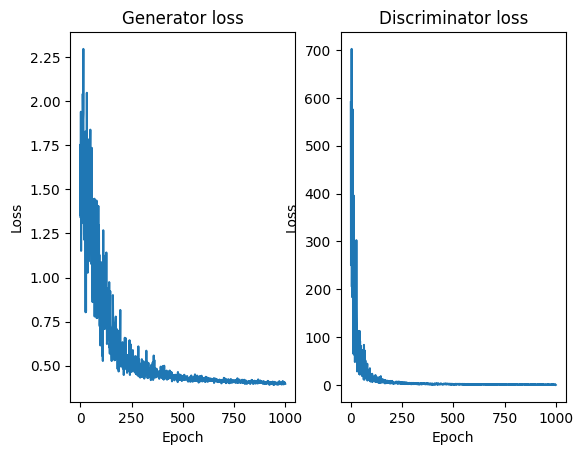

In [ ]:
from matplotlib import pyplot as plt
print(history.history.keys()) #dict_keys(['d0_loss', 'g0_loss'])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['g0_loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.set_title('Generator loss')
ax2.plot(history.history['d0_loss'])
ax2.set_title('Discriminator loss')
# plt.xscale('log')
ax2.set(xlabel='Epoch', ylabel='Loss')
#plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()


In [ ]:
### Recontruct from voxels to mesh

# !pip install trimesh
# !pip install PyMCubes

import trimesh
import numpy as np
from mcubes import marching_cubes
import pandas as pd

# normalise within unit sphere:
def normalize_unit_sphere(vertices):
  mean_vertices = np.mean(vertices, axis=0)
  vertices -= mean_vertices # mean subtracted from all vertices
  max_distance = np.max(np.sqrt(np.sum(abs(vertices)**2,axis=-1))) #max distance from origin
  vertices /= max_distance #all vertices are divided by the maximum of such distances
  #All distances are scaled to the range -1.0 and 1.0.
  return vertices

# Convert the tensor data into a trimesh volume
loaded_voxels = np.loadtxt("generated_shape_0_0.txt")
load_original_voxels = loaded_voxels.reshape(
    loaded_voxels.shape[0], loaded_voxels.shape[1] // original_voxels.shape[2], original_voxels.shape[2])
vertices, faces = marching_cubes(load_original_voxels, 0.5)
#print(vertices)
#normalise vertices
vertices = normalize_unit_sphere(vertices)
volume_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
print(volume_mesh)
volume_mesh.show()


<trimesh.Trimesh(vertices.shape=(10054, 3), faces.shape=(19725, 3))>


In [ ]:
# @title Generator N included

#paper uses WGAP_GP method
class WGAN(keras.Model):
    def __init__(
        self,
        projection_model,
        generator0,
        generatorN,
        mlp_small,
        mlp_big,
        discriminator_small,
        discriminator_big,
        original_input_shape, #  (115, 179, 106)
        # generator_loss_list,
        # discriminator_loss_list,
        gradient_penalty_weight = 0.1,
        out_channels = 32,
    ):
        super().__init__()
        self.projection_model = projection_model
        self.generator0 = generator0
        self.generatorN = generatorN
        self.mlp_small = mlp_small
        self.mlp_big = mlp_big
        self.discriminator_small = discriminator_small
        self.discriminator_big = discriminator_big
        self.original_input_shape = original_input_shape # (115, 179, 106)
        self.gradient_penalty_weight = gradient_penalty_weight
        self.out_channels = out_channels
        # self.generator_loss_list = generator_loss_list
        # self.discriminator_loss_list = discriminator_loss_list


    def compile(self, discriminator_optimizer, generator_optimizer, recontruction_loss_fn, adversarial_loss_fn):
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.recontruction_loss_fn = recontruction_loss_fn #discriminator losss
        self.adversarial_loss_fn = adversarial_loss_fn #generator loss

    def gradient_penalty(self, batch_size, real_scores, fake_scores):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_scores - real_scores
        interpolated = real_scores + epsilon * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Choose correct discriminator
            if real_scores.shape[-3:] == (115, 179, 106):
              pred = self.discriminator_small(interpolated, training=True)
            else:
              pred = self.discriminator_big(interpolated, training=True)
        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, real_voxels, big_real_voxels=tf.expand_dims(big_voxels,0)):
        # Get the batch size
        batch_size = 1

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as gen0_tape, tf.GradientTape() as genN_tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_small = self.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
          input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_small), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen0_score_map = self.discriminator_small([input_voxels], training=True)
          # Get the logits for the real occupancy score maps
          original_input_voxels = tf.tile(tf.expand_dims(real_voxels, 0), [1,self.out_channels, 1, 1, 1])
          original_score_map = self.discriminator_small([original_input_voxels], training=True)
          # Calculate the discriminator loss using the fake and real score maps
          d_cost_small = self.recontruction_loss_fn(real=original_score_map, reconstructed=gen0_score_map)
          # Calculate the gradient penalty
          #gp = self.gradient_penalty(batch_size,original_score_map, gen0_score_map)
          gp = self.gradient_penalty(batch_size,tf.cast(original_input_voxels, tf.float32), tf.squeeze(o_p_small))
          # Add the gradient penalty to the original discriminator loss
          small_d_loss = d_cost_small + gp * self.gradient_penalty_weight

          ##Generator N
          yz_tmap_out, xz_tmap_out, xy_tmap_out = self.generatorN([yz_tmap, xz_tmap, xy_tmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_big = self.mlp_big([yz_tmap_out, xz_tmap_out, xy_tmap_out], training=True)
          #seems big_input_voxels already assigned elsewhere
          big_input_voxel = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_big), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          genN_score_map = self.discriminator_big([big_input_voxel], training=True)
          # Get the logits for the real occupancy score maps
          #seems big_original_input_voxels already assigned elsewhere
          big_original_input_voxel = tf.tile(tf.expand_dims(big_real_voxels, 0), [1,self.out_channels, 1, 1, 1])
          big_original_score_map = self.discriminator_big([big_original_input_voxel], training=True)
          # Calculate the discriminator loss using the fake and real score maps
          d_cost_big = self.recontruction_loss_fn(real=big_original_score_map, reconstructed=genN_score_map)
          # Calculate the gradient penalty
          #big_gp = self.gradient_penalty(batch_size, big_original_score_map,genN_score_map)
          big_gp = self.gradient_penalty(batch_size,tf.cast(big_original_input_voxel, tf.float32), tf.squeeze(o_p_big))

          # Add the gradient penalty to the original discriminator loss
          big_d_loss = d_cost_big + big_gp * self.gradient_penalty_weight
          #d_loss = small_d_loss+big_d_loss

          # Get the gradients w.r.t the discriminator loss
          small_d_gradient = gen0_tape.gradient(small_d_loss, self.discriminator_small.trainable_variables)
          big_d_gradient = genN_tape.gradient(big_d_loss, self.discriminator_big.trainable_variables)
          #d_gradient = tape.gradient(d_loss, [self.discriminator_small.trainable_variables, self.discriminator_big.trainable_variables])
          #d_gradient = tape.gradient(d_loss, self.discriminator_small.trainable_variables+self.discriminator_big.trainable_variables)

          # Update the weights of the discriminator using the discriminator optimizer
          # self.discriminator_optimizer.apply_gradients(
          #     zip(d_gradient, self.discriminator_small.trainable_variables+self.discriminator_big.trainable_variables)
          #)
          self.discriminator_optimizer.apply_gradients(
              zip(small_d_gradient, self.discriminator_small.trainable_variables)
          )
          self.discriminator_optimizer.apply_gradients(
              zip(big_d_gradient, self.discriminator_big.trainable_variables)
          )

        # Train the generator
        # Get the latent vector
        random_latent_map = tf.random.normal(
            shape=(batch_size, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, self.out_channels, 1, 1, 1])
        with tf.GradientTape() as d0_tape, tf.GradientTape() as dN_tape:
          # Create tri-plane projection from random latent map
          yz_fmap, xz_fmap, xy_fmap = self.projection_model(random_latent_map, training=True)
          ##Generator 0
          # Generate feature maps from the projection feature planes
          yz_tmap, xz_tmap, xy_tmap = self.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_small = self.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
          input_voxels = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_small), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          gen0_score_map = self.discriminator_small([input_voxels], training=True)
          # Calculate the generator loss
          small_g_loss = self.adversarial_loss_fn(gen0_score_map)

          ##Generator N
          yz_tmap_out, xz_tmap_out, xy_tmap_out = self.generatorN([yz_tmap, xz_tmap, xy_tmap], training=True)
          # Generate fake voxels from the feature maps
          o_p_big = self.mlp_big([yz_tmap_out, xz_tmap_out, xy_tmap_out], training=True)
          big_input_voxel = tf.tile(tf.expand_dims(tf.expand_dims(tf.squeeze(o_p_big), 0), 0), [1,self.out_channels, 1, 1, 1])
          # Get the logits for the fake occupancy score maps
          genN_score_map = self.discriminator_big([big_input_voxel], training=True)
          # Calculate the generator loss
          big_g_loss = self.adversarial_loss_fn(genN_score_map)
          #g_loss =  tf.math.reduce_mean([small_g_loss, big_d_loss])

        # Get the gradients w.r.t the generators loss
        # gen_gradient = tape.gradient(g_loss, [self.generator0.trainable_variables,self.generatorN.trainable_variables])
        gen0_gradient = d0_tape.gradient(small_g_loss, self.generator0.trainable_variables)
        genN_gradient = dN_tape.gradient(big_g_loss, self.generatorN.trainable_variables)

        # Update the weights of the generator using the generator optimizer
        self.generator_optimizer.apply_gradients(
            zip(gen0_gradient, self.generator0.trainable_variables)
        )
        self.generator_optimizer.apply_gradients(
            zip(genN_gradient, self.generatorN.trainable_variables)
        )
        # return {"d0_loss": small_d_loss,"dN_loss": big_d_loss, "g0_loss": small_g_loss,"gN_loss": big_g_loss}
        # self.discriminator_loss_list.append(small_d_loss)
        # self.generator_loss_list.append(small_g_loss)
        return {"d0_loss": small_d_loss, "g0_loss": small_g_loss}
        # return {"d_loss": small_d_loss, "g_loss": small_g_loss}

In [ ]:
import tensorflow.keras.backend as K
# Hyperparameters
lr = 1e-4
beta1 = 0.5#exponential decay rate
epoch = 1000#2000 #000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=epoch,
    decay_rate=beta1)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

#Losses
"""The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). """
#@tf.function
def adversarial_loss(y_pred):#generator loss
    return K.mean(y_pred) #aims to be around +0, tutorial usies -, but repo using +

#@tf.function
def reconstruction_loss(real, reconstructed): #discriminator loss
  alpha = 10
  mse = tf.keras.losses.MeanSquaredError()#mse(y_true, y_pred)
  loss = alpha*mse(real, reconstructed)
  return loss

In [ ]:
#Create a Keras callback that periodically saves shapes
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_gen=2, original_input_shape=(115, 179, 106)):
        self.num_gen = num_gen
        self.original_input_shape = original_input_shape

    def on_epoch_end(self, epoch, logs=None):
        random_latent_map = tf.random.normal(
            shape=(1, *self.original_input_shape)
        )
        random_latent_map = tf.tile(tf.expand_dims(random_latent_map, 1), [1, 32, 1, 1, 1])
        # Create tri-plane projection from random latent map
        yz_fmap, xz_fmap, xy_fmap = self.model.projection_model(random_latent_map, training=True)
        ##Generator 0
        # Generate feature maps from the projection feature planes
        yz_tmap, xz_tmap, xy_tmap = self.model.generator0([yz_fmap, xz_fmap, xy_fmap], training=True)
        # Generate fake voxels from the feature maps
        o_p_small = self.model.mlp_small([yz_tmap, xz_tmap, xy_tmap], training=True)
        if (epoch) % 10 == 0:
            for i in range(self.num_gen):
                voxels = tf.squeeze(o_p_small).numpy()
                print(voxels.shape)
                #break 3D array to 2d
                voxels_reshaped = voxels.reshape(voxels.shape[0], -1)
                np.savetxt("generated_shape_{i}_{epoch}.txt".format(i=i, epoch=epoch), voxels_reshaped)

In [ ]:
##train end-to end
# Instantiate the customer `GANMonitor` Keras callback.
print(original_voxels.shape)
cbk = GANMonitor(num_gen=2, original_input_shape=original_voxels.shape)
generator_loss_list = []
discriminator_loss_list = []
# Get the wgan model
wgan = WGAN(
        projection_model = projection_model,
        generator0 = generator0_model,
        generatorN = generatorN_model,
        mlp_small = mlp_small,
        mlp_big = mlp_big,
        discriminator_small = discriminator_small,
        discriminator_big = discriminator_big,
        original_input_shape = original_voxels.shape,
        # generator_loss_list = generator_loss_list,
        # discriminator_loss_list = discriminator_loss_list
)

# Compile the wgan model
wgan.compile(
    discriminator_optimizer=discriminator_optimizer,
    generator_optimizer=generator_optimizer,
    adversarial_loss_fn=adversarial_loss,
    recontruction_loss_fn=reconstruction_loss,
)
early_stopping_cbk = tf.keras.callbacks.EarlyStopping(monitor="d0_loss", patience=20)
# Start training
history = wgan.fit(tf.expand_dims(original_voxels,0), batch_size=1, epochs=epoch, callbacks=[cbk, early_stopping_cbk])

(115, 179, 106)
Epoch 1/1000
1/1 [==============================] - ETA: 0s - d0_loss: 132.7563 - g0_loss: -0.0210(115, 179, 106)
(115, 179, 106)
1/1 [==============================] - 7s 7s/step - d0_loss: 132.7563 - g0_loss: -0.0210
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 306.3756 - g0_loss: -0.0378
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 101.6184 - g0_loss: 0.0123
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 364.4023 - g0_loss: -0.0181
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 89.3392 - g0_loss: -0.0167
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 263.4450 - g0_loss: -0.0076
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 205.6992 - g0_loss: -0.0813
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - d0_loss: 328.6751 - g0_loss: -0.0058
Epoch 9/1000
1/1 [==============================] - 1

dict_keys(['d0_loss', 'g0_loss'])


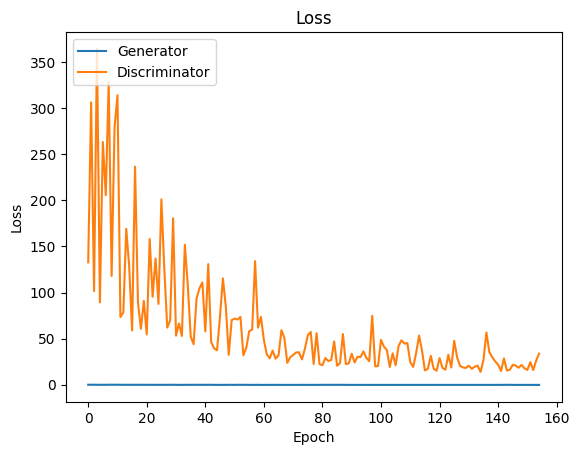

In [ ]:
from matplotlib import pyplot as plt
print(history.history.keys()) #dict_keys(['d0_loss', 'g0_loss'])
plt.plot(history.history['g0_loss'])
plt.plot(history.history['d0_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()


In [ ]:
### Recontruct from voxels to mesh

# !pip install trimesh
# !pip install PyMCubes

import trimesh
import numpy as np
from mcubes import marching_cubes
import pandas as pd

# normalise within unit sphere:
def normalize_unit_sphere(vertices):
  mean_vertices = np.mean(vertices, axis=0)
  vertices -= mean_vertices # mean subtracted from all vertices
  max_distance = np.max(np.sqrt(np.sum(abs(vertices)**2,axis=-1))) #max distance from origin
  vertices /= max_distance #all vertices are divided by the maximum of such distances
  #All distances are scaled to the range -1.0 and 1.0.
  return vertices

# Convert the tensor data into a trimesh volume
loaded_voxels = np.loadtxt("generated_shape_1_130.txt")
load_original_voxels = loaded_voxels.reshape(
    loaded_voxels.shape[0], loaded_voxels.shape[1] // original_voxels.shape[2], original_voxels.shape[2])
vertices, faces = marching_cubes(load_original_voxels, 0.5)
#print(vertices)
#normalise vertices
vertices = normalize_unit_sphere(vertices)
volume_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
print(volume_mesh)
volume_mesh.show()


<trimesh.Trimesh(vertices.shape=(8669, 3), faces.shape=(16969, 3))>
